In [8]:
from math import nan
from re import compile

from numpy import arange, array_equal
from pandas import read_csv, DataFrame, concat, Series, isna
from pingouin import ttest
from seaborn import set_style, color_palette, lineplot, FacetGrid, set_theme

In [9]:
measures = DataFrame([
    {"name": "nDCG@5 rel.", "display_name": r"nDCG@5 relevance", "maximize": True, },
    {"name": "nDCG@5 qual.", "display_name": r"nDCG@5 quality", "maximize": True, },
])
measures

,name,display_name,maximize
0,nDCG@5 rel.,nDCG@5 relevance,True
1,nDCG@5 qual.,nDCG@5 quality,True


In [10]:
def target_f1(name: str) -> float:
    parts = name.split(" + ")
    for part in parts:
        if part.startswith("randomize"):
            match = compile(r"randomize\(F1<=(.*)\)").match(part)
            if not match:
                return 1.0
            return float(match.group(1))
    if "ground-truth" in parts:
        return 1.0
    return nan

In [83]:
df: DataFrame = read_csv("../data/metrics-reranking.csv")

# Remove duplicate runs.
df = df.groupby(["name", "qid"], dropna=False, sort=False).aggregate("first").reset_index()

# Pivot measures into column values.
df = concat([
    concat([
        df[["name", "qid", measure]].rename(columns={measure: "value"}),
        DataFrame({"measure": [measure] * len(df)}),
    ], axis=1)
    for measure in measures["name"]
])

# Add run/team/reranker names.
df["run"] = df["name"].apply(lambda name: name.split(" + ", maxsplit=1)[0])
df["team"] = df["run"].apply(lambda run: run.split(" ", maxsplit=1)[0])
df["reranker"] = [
    name.split(" + ", maxsplit=1)[1] if name != run else nan
    for _, (name, run) in df[["name", "run"]].iterrows()
]

# Detect target F1 scores.
df["target_f1"] = df["name"].apply(target_f1)

# Select columns.
df = df[["name", "team", "run", "reranker", "target_f1", "qid", "measure", "value"]]

# Compute aggregated metric values.
df_aggregated = df[["name", "measure", "qid", "value"]].groupby(["name", "measure"], dropna=False,
                                                                sort=False).aggregate("mean").drop(
    columns=["qid"])
df = df.merge(df_aggregated, on=["name", "measure"], suffixes=("", "_aggregated"))

# Add differences to original runs.
df = df.merge(
    df[df["reranker"].isna()][["qid", "measure", "run", "value", "value_aggregated"]],
    on=["qid", "measure", "run"],
    suffixes=("", "_original"),
).rename(columns={"value_aggregated_original": "value_original_aggregated"})
df["difference_original"] = df["value"] - df["value_original"]
df["difference_original_aggregated"] = df["value_aggregated"] - df["value_original_aggregated"]

df

,name,team,run,reranker,target_f1,qid,measure,value,value_aggregated,value_original,value_original_aggregated,difference_original,difference_original_aggregated
0,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,NaN,NaN,100,nDCG@5 rel.,0.170,0.54662,0.170,0.54662,0.000,0.00000
1,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,ground-truth + stance-first@5,1.00,100,nDCG@5 rel.,0.339,0.57594,0.170,0.54662,0.169,0.02932
2,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,stance-first@5,NaN,100,nDCG@5 rel.,0.170,0.54642,0.170,0.54662,0.000,-0.00020
3,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,gpt3-tsv + stance-first@5,NaN,100,nDCG@5 rel.,0.170,0.55900,0.170,0.54662,0.000,0.01238
4,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,roberta-csv + stance-first@5,NaN,100,nDCG@5 rel.,0.339,0.55124,0.170,0.54662,0.169,0.00462
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57195,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.40)@5 + stance-...,0.40,95,nDCG@5 qual.,0.361,0.48602,0.361,0.47622,0.000,0.00980
57196,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.35)@5 + stance-...,0.35,95,nDCG@5 qual.,0.361,0.48246,0.361,0.47622,0.000,0.00624
57197,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.30)@5 + stance-...,0.30,95,nDCG@5 qual.,0.327,0.46664,0.361,0.47622,-0.034,-0.00958
57198,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.25)@5 + stance-...,0.25,95,nDCG@5 qual.,0.327,0.47548,0.361,0.47622,-0.034,-0.00074


In [86]:
short_team_names = {}
team: str
for team in df["team"].sort_values().unique():
    orig_team = team
    for prefix in ["Captain", "Olivier", "Puss-in"]:
        if team.startswith(prefix):
            team = prefix + team.removeprefix(prefix)[:2] + "."
    short_team_names[orig_team] = team.replace("-", " ")
short_team_names

{'Aldo-Nadi': 'Aldo Nadi',
 'Asuna': 'Asuna',
 'Captain-Levi': 'Captain L.',
 'Captain-Tempesta': 'Captain T.',
 'Grimjack': 'Grimjack',
 'Katana': 'Katana',
 'Olivier-Armstrong': 'Olivier A.',
 'Puss-in-Boots': 'Puss in B.'}

In [87]:
short_run_names = {}
for team in df["team"].unique():
    for run, char in zip(df[df["team"] == team]["run"].sort_values().unique(), "ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
        short_run_names[(team, run)] = char
short_run_names

{('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_RF_reranked'): 'A',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_false_porter'): 'B',
 ('Aldo-Nadi',
  'Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_false_porter_reranked'): 'C',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_rrf'): 'D',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_rrf_reranked'): 'E',
 ('Asuna', 'Asuna asuna-run-5'): 'A',
 ('Captain-Levi', 'Captain-Levi levirank_baseline_large_duo_t5'): 'A',
 ('Captain-Levi', 'Captain-Levi levirank_dense_initial_retrieval'): 'B',
 ('Captain-Levi', 'Captain-Levi levirank_psuedo_relevance_feedback'): 'C',
 ('Captain-Levi',
  'Captain-Levi levirank_psuedo_relevance_feedback+voting'): 'D',
 ('Captain-Levi', 'Captain-Levi levirank_voting_retrieval'): 'E',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_1'): 'A',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_2'): 'B',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_3'): 'C',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_4'): 'D

In [91]:
print(r"\begin{tabular}{@{}lll@{}}")
print(r"    \toprule")
print(r"    \multicolumn{2}{@{}l}{Run} & Run ID \\")
print(r"    \midrule")
for team in df["team"].sort_values().unique():
    for run in df[df["team"] == team]["run"].sort_values().unique():
        print(f"    {team.replace('-', ' ')} & {short_run_names[(team, run)]} & {run.removeprefix(team)[1:]} \\\\")
print(r"    \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{@{}lll@{}}
    \toprule
    \multicolumn{2}{@{}l}{Run} & Run ID \\
    \midrule
    Aldo Nadi & A & seupd2122-kueri_RF_reranked \\
    Aldo Nadi & B & seupd2122-kueri_kueristopv2_BM2_false_porter \\
    Aldo Nadi & C & seupd2122-kueri_kueristopv2_BM2_false_porter_reranked \\
    Aldo Nadi & D & seupd2122-kueri_rrf \\
    Aldo Nadi & E & seupd2122-kueri_rrf_reranked \\
    Asuna & A & asuna-run-5 \\
    Captain Levi & A & levirank_baseline_large_duo_t5 \\
    Captain Levi & B & levirank_dense_initial_retrieval \\
    Captain Levi & C & levirank_psuedo_relevance_feedback \\
    Captain Levi & D & levirank_psuedo_relevance_feedback+voting \\
    Captain Levi & E & levirank_voting_retrieval \\
    Captain Tempesta & A & hextech_run_1 \\
    Captain Tempesta & B & hextech_run_2 \\
    Captain Tempesta & C & hextech_run_3 \\
    Captain Tempesta & D & hextech_run_4 \\
    Captain Tempesta & E & hextech_run_5 \\
    Grimjack & A & grimjack-all-you-need-is-t0 \\
    Grimjack & 

In [134]:
rerankers_table = {
    nan: r"Touch{\'e}",
    "ground-truth + stance-first@5": r"Oracle~{\tiny(\fone=\,1.00)}",
    "ground-truth + randomize(F1<=0.75)@5 + stance-first@5": r"Random~{\tiny(\fone<\,0.75)}",
    "gpt3-tsv + stance-first@5": r"GPT-3~{\tiny(\fone=\,0.49)}",
    "google/flan-t5-base@5 + stance-first@5": r"Flan-T5~{\tiny(\fone=\,0.39)}",
    "roberta-csv + stance-first@5": r"\kern-0.25em RoBERTa~{\tiny(\fone=\,0.34)}\kern-0.25em",
    "stance-first@5": r"Original~{\tiny(\fone<\,0.36)}",
}
correction_n = len(rerankers_table) + 1

for key in rerankers_table.keys():
    if (not isna(key) and len(df[df["reranker"] == key]) == 0) or (isna(key) and len(df[df["reranker"].isna()]) == 0):
        raise ValueError(f"Re-ranker '{key}' not found.")

In [164]:
df_table = df[
    df["reranker"].isin(rerankers_table.keys()) |
    df["reranker"].isna()
    ]
reranker_index = {
    reranker: i
    for i, reranker in enumerate(rerankers_table.keys())
}


def table_row(df: DataFrame, measure_name: str, run: str, reranker: str) -> Series:
    measure = measures[measures["name"] == measure_name].iloc[0]

    df_reranked = df[df["run"] == run]
    if isna(reranker):
        df_reranked = df_reranked[df_reranked["reranker"].isna()]
    else:
        df_reranked = df_reranked[df_reranked["reranker"] == reranker]

    df_originals = df[df["reranker"].isna()]
    df_originals = df_originals.sort_values("run").sort_values("value_aggregated", ascending=not measure["maximize"])
    run_ranks_original = {run: i + 1 for i, run in enumerate(df_originals["run"].unique())}
    run_rank_original = run_ranks_original[run]
    df_leaderboard = concat([
        df_originals[df_originals["run"] != run],
        df_reranked,
    ])
    df_leaderboard = df_leaderboard.sort_values("run").sort_values("value_aggregated",
                                                                   ascending=not measure["maximize"])
    run_ranks = {run: i + 1 for i, run in enumerate(df_leaderboard["run"].unique())}
    run_rank = run_ranks[run]

    df_original = df_originals[df_originals["run"] == run]

    df_reranked = df_reranked.sort_values("qid")
    df_original = df_original.sort_values("qid")

    if not array_equal(df_original["value"], df_reranked["value"]):
        stats = ttest(df_original["value"], df_reranked["value"], paired=True)
    else:
        stats = DataFrame({
            "p-val": [nan],
            "CI95%": [(nan, nan)],
            "cohen-d": [nan],
        })

    res: Series = df_reranked[[
        "name", "team", "run", "reranker", "measure",
        "value_aggregated", "value_original_aggregated", "difference_original_aggregated"
    ]].iloc[0]
    res["run_rank"] = run_rank
    res["run_rank_original"] = run_rank_original
    res["reranker_index"] = reranker_index[reranker]
    res["p_value"] = stats["p-val"].iloc[0]
    res["p_value_corrected"] = stats["p-val"].iloc[0] * correction_n
    res["ci95_low"] = stats["CI95%"].iloc[0][0]
    res["ci95_high"] = stats["CI95%"].iloc[0][1]
    res["cohen_d"] = stats["cohen-d"].iloc[0]
    return res


df_table = DataFrame([
    table_row(
        df_table_measure,
        measure,
        run,
        reranker,
    )
    for reranker in rerankers_table.keys()
    for measure, df_table_measure in df_table.groupby("measure", dropna=False, sort=False)
    for run in df_table["run"].unique()
])

df_table.sort_values(["measure", "reranker_index", "run_rank"], ascending=[False, True, True], inplace=True)

df_table

,name,team,run,reranker,measure,value_aggregated,value_original_aggregated,difference_original_aggregated,run_rank,run_rank_original,reranker_index,p_value,p_value_corrected,ci95_low,ci95_high,cohen_d
10032,Captain-Levi levirank_dense_initial_retrieval,Captain-Levi,Captain-Levi levirank_dense_initial_retrieval,NaN,nDCG@5 rel.,0.75772,0.75772,0.0,1,1,0,NaN,NaN,NaN,NaN,NaN
8932,Captain-Levi levirank_baseline_large_duo_t5,Captain-Levi,Captain-Levi levirank_baseline_large_duo_t5,NaN,nDCG@5 rel.,0.75512,0.75512,0.0,2,2,0,NaN,NaN,NaN,NaN,NaN
11132,Captain-Levi levirank_psuedo_relevance_feedbac...,Captain-Levi,Captain-Levi levirank_psuedo_relevance_feedbac...,NaN,nDCG@5 rel.,0.75280,0.75280,0.0,3,3,0,NaN,NaN,NaN,NaN,NaN
6732,Captain-Levi levirank_voting_retrieval,Captain-Levi,Captain-Levi levirank_voting_retrieval,NaN,nDCG@5 rel.,0.72734,0.72734,0.0,4,4,0,NaN,NaN,NaN,NaN,NaN
7832,Captain-Levi levirank_psuedo_relevance_feedback,Captain-Levi,Captain-Levi levirank_psuedo_relevance_feedback,NaN,nDCG@5 rel.,0.72146,0.72146,0.0,5,5,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50734,Grimjack grimjack-fair-argumentative-reranking...,Grimjack,Grimjack grimjack-fair-argumentative-reranking...,stance-first@5,nDCG@5 qual.,0.36526,0.36526,0.0,22,22,6,NaN,NaN,NaN,NaN,NaN
46334,Grimjack grimjack-baseline + stance-first@5,Grimjack,Grimjack grimjack-baseline,stance-first@5,nDCG@5 qual.,0.36342,0.36342,0.0,23,23,6,NaN,NaN,NaN,NaN,NaN
47434,Grimjack grimjack-argumentative-axioms + stanc...,Grimjack,Grimjack grimjack-argumentative-axioms,stance-first@5,nDCG@5 qual.,0.36342,0.36342,0.0,24,24,6,NaN,NaN,NaN,NaN,NaN
49634,Grimjack grimjack-all-you-need-is-t0 + stance-...,Grimjack,Grimjack grimjack-all-you-need-is-t0,stance-first@5,nDCG@5 qual.,0.34436,0.34436,0.0,25,25,6,NaN,NaN,NaN,NaN,NaN


In [165]:
# TODO: Report for each run: optimal achievable ndcg when re-ranking top-5
# TODO: Flan raus

In [178]:
extra_space_em = 1.55
col_sep_em = 0.38
parts = ["l", r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}", "l"]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    parts.append(r"@{\hspace{" + f"{extra_space_em}" + r"em}}")
    if isna(reranker):
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}")
        parts.append("r")
    else:
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}")
        parts.append("r")
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}")
        parts.append("r")
print(r"\renewcommand{\tabcolsep}{" + f"{col_sep_em}" + r"em}")
print(r"\begin{tabular}{@{}" + "".join(parts) + r"@{}}")
print(r"    \toprule")

parts = [r"\multicolumn{2}{@{}l}{\textbf{Run}}"]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "\hspace{" + f"{extra_space_em}" + "em}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        reranker = rerankers_table[nan]
        parts.append("\multicolumn{2}{@{}c@{" + space + r"}}{\textbf{" + reranker + r"}}")
    else:
        reranker = rerankers_table[reranker]
        parts.append(r"\multicolumn{4}{@{}c@{" + space + r"}}{\textbf{" + reranker + r"}}")
print("    " + " & ".join(parts) + r" \\")

parts = []
col = 3
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "r{" + f"{extra_space_em}" + "em}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col + 1) + "}")
        col += 2
    else:
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col + 3) + "}")
        col += 4
print("    " + "".join(parts))

parts = ["", ""]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "\hspace{" + f"{extra_space_em}" + "em}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        parts.append(r"Val.")
        parts.append(r"\#")
    else:
        parts.append(r"Val.")
        parts.append(r"{\tiny$\Delta$}")
        parts.append(r"\#")
        parts.append(r"{\tiny$\Delta$}")
print("    " + " & ".join(parts) + r" \\")
print(r"    \midrule")

rank_worse = r"{\tiny$\downarrow$}"
rank_better = r"{\tiny$\uparrow$}"
rank_equal = r"{\tiny$\phantom{\uparrow}$}"
for i, (measure_name, df_measure) in enumerate(df_table.groupby("measure", dropna=False, sort=False)):
    measure = measures[measures["name"] == measure_name].iloc[0]
    measure_display_name = measure["display_name"]
    if measure_display_name == "nDCG@5 relevance":
        measure_display_name = r"nDCG@5 evaluated using relevance labels"
    elif measure_display_name == "nDCG@5 quality":
        measure_display_name = r"nDCG@5 evaluated using argument quality labels"
    df_measure = df_measure.sort_values("run_rank_original")
    if i > 0:
        print(r"    \midrule")
    print(r"    \multicolumn{" + str(len(parts)) + r"}{@{}l@{}}{\textit{" + measure_display_name + r"}} \\")
    print(r"    \midrule")
    for (team, run), df_run in df_measure.groupby(["team", "run"], dropna=False, sort=False):
        df_run = df_run.sort_values("reranker_index")
        short_team = short_team_names[team]
        short_run = short_run_names[(team, run)]
        short_team = short_team.replace("_", r"\_")
        short_run = short_run.replace("_", r"\_")
        parts = [short_team, short_run]
        for reranker, df_reranker in df_run.groupby("reranker", dropna=False, sort=False):
            value_aggregated = df_reranker["value_aggregated"].iloc[0]
            difference_original_aggregated = df_reranker["difference_original_aggregated"].iloc[0]
            run_rank = df_reranker["run_rank"].iloc[0]
            run_rank_original = df_reranker["run_rank_original"].iloc[0]
            run_rank_difference = run_rank - run_rank_original
            if isna(reranker):
                parts.append(f"{value_aggregated:.2f}")
                parts.append(f"{run_rank:.0f}")
            else:
                hidden = "Original" in rerankers_table[reranker] and df_reranker["team"].iloc[0] in ("Aldo-Nadi", "Captain-Tempesta")
                val_str = f"{value_aggregated:.2f}"
                if df_reranker["p_value_corrected"].iloc[0] < 0.05:
                    val_str = r"\textbf{" + val_str + r"}"
                if hidden:
                    val_str = r"\hidden{" + val_str + r"}"
                parts.append(val_str)
                diff_str = f"{'+' if difference_original_aggregated.round(2) >= 0 else '-'}{abs(difference_original_aggregated):.2f}"
                if df_reranker["p_value_corrected"].iloc[0] < 0.05:
                    diff_str = r"\textbf{" + diff_str + r"}"
                if hidden:
                    diff_str = r"\hidden{" + diff_str + r"}"
                parts.append(diff_str)
                rank_str = f"{run_rank:.0f}"
                if hidden:
                    rank_str = r"\hidden{" + rank_str + r"}"
                parts.append(rank_str)
                rank_diff_str = f"{rank_worse if run_rank_difference > 0 else rank_better if run_rank_difference < 0 else rank_equal}{abs(run_rank_difference):.0f}"
                if hidden:
                    rank_diff_str = r"\hidden{" + rank_diff_str + r"}"
                parts.append(rank_diff_str                                 )
        print("    " + " & ".join(parts) + r" \\")

print(r"    \bottomrule")
print(r"\end{tabular}")

\renewcommand{\tabcolsep}{0.38em}
\begin{tabular}{@{}l@{\hspace{0.342em}}l@{\hspace{1.55em}}r@{\hspace{0.342em}}r@{\hspace{1.55em}}r@{\hspace{0.342em}}rr@{\hspace{0.342em}}r@{\hspace{1.55em}}r@{\hspace{0.342em}}rr@{\hspace{0.342em}}r@{\hspace{1.55em}}r@{\hspace{0.342em}}rr@{\hspace{0.342em}}r@{\hspace{1.55em}}r@{\hspace{0.342em}}rr@{\hspace{0.342em}}r@{\hspace{1.55em}}r@{\hspace{0.342em}}rr@{\hspace{0.342em}}r@{\hspace{1.55em}}r@{\hspace{0.342em}}rr@{\hspace{0.342em}}r@{}}
    \toprule
    \multicolumn{2}{@{}l}{\textbf{Run}} & \multicolumn{2}{@{}c@{\hspace{1.55em}}}{\textbf{Touch{\'e}}} & \multicolumn{4}{@{}c@{\hspace{1.55em}}}{\textbf{Oracle~{\tiny(\fone=\,1.00)}}} & \multicolumn{4}{@{}c@{\hspace{1.55em}}}{\textbf{Random~{\tiny(\fone<\,0.75)}}} & \multicolumn{4}{@{}c@{\hspace{1.55em}}}{\textbf{GPT-3~{\tiny(\fone=\,0.49)}}} & \multicolumn{4}{@{}c@{\hspace{1.55em}}}{\textbf{Flan-T5~{\tiny(\fone=\,0.39)}}} & \multicolumn{4}{@{}c@{\hspace{1.55em}}}{\textbf{\kern-0.25em RoBERTa~{\tiny(\fon

In [195]:
difference_data = []
df_tmp = df[~df["target_f1"].isna()]
for (measure_name, team), df_team in df_tmp.groupby(["measure", "team"]):
    measure = measures[measures["name"] == measure_name].iloc[0]
    # run = df_team.sort_values("value_original_aggregated" , ascending=not measure["maximize"])["run"].iloc[0]
    # df_team = df_team[df_team["run"] == run]
    for (target_f1, qid, run), df_group in df_team.groupby(["target_f1", "qid", "run"]):
        assert len(df_group) == 1
        difference_data.append({
            "team": team,
            "run": run,
            "target_f1": target_f1,
            "measure": measure["display_name"],
            "qid": qid,
            "difference": df_group["difference_original"].iloc[0],
        })
differences = DataFrame(difference_data)
differences

,team,run,target_f1,measure,qid,difference
0,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_RF_reranked,0.2,nDCG@5 quality,2,0.074
1,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,0.2,nDCG@5 quality,2,0.000
2,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,0.2,nDCG@5 quality,2,0.000
3,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_rrf,0.2,nDCG@5 quality,2,0.000
4,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.2,nDCG@5 quality,2,0.000
...,...,...,...,...,...,...
44195,Puss-in-Boots,Puss-in-Boots BM25-Baseline,1.0,nDCG@5 relevance,91,0.000
44196,Puss-in-Boots,Puss-in-Boots BM25-Baseline,1.0,nDCG@5 relevance,92,0.078
44197,Puss-in-Boots,Puss-in-Boots BM25-Baseline,1.0,nDCG@5 relevance,93,0.000
44198,Puss-in-Boots,Puss-in-Boots BM25-Baseline,1.0,nDCG@5 relevance,95,0.085


In [196]:
first_bin = 0.2
last_bin = 1.00
bin_step = 0.05
bins = list(arange(
    first_bin - (bin_step / 2),
    last_bin + (bin_step / 2) + 0.0001,
    bin_step,
))
# bins

In [197]:
width = 4

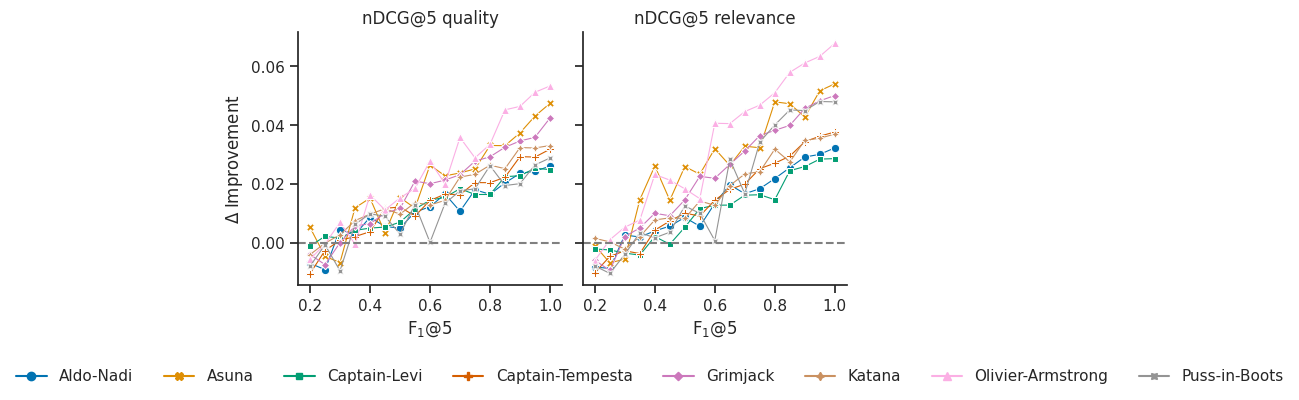

In [199]:
set_theme()
set_style("ticks")
aspect = 1.1
df_plot_differences = differences.copy()
df_plot_differences = df_plot_differences[df_plot_differences["target_f1"] >= first_bin]
plot_differences = FacetGrid(
    data=df_plot_differences,
    col="measure",
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_differences.map_dataframe(
    lineplot,
    x="target_f1",
    y="difference",
    hue="team",
    hue_order=df_plot_differences["team"].sort_values().unique(),
    palette=color_palette("colorblind")[:len(df_plot_differences["team"].unique())],
    markers=True,
    dashes=False,
    style="team",
    err_style=None,
    # err_style="band",
    # err_kws=dict(
    #     alpha=0.05,
    # ),
    linewidth=0.8,
)
plot_differences.refline(y=0)
plot_differences.set_xlabels(r"F$_1$@5")
plot_differences.set_ylabels(r"$\Delta$ Improvement")
plot_differences.add_legend(
    loc="upper center",
    ncols=len(df_plot_differences["team"].unique()),
    bbox_to_anchor=(0.28, 0),
)
plot_differences.set_titles(col_template="{col_name}")
# plot_differences.savefig("data/plot-reranking-f1-difference-best-run.pdf", transparent=True)
# plot_differences.savefig("data/plot-reranking-f1-difference-best-run.png")
plot_differences